- Libraries

In [1]:
import pandas as pd
import numpy as np
from DateTime import DateTime
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse
# from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")
from src.functions_torch import TransformLag
from src.feature import TimeConfig


In [2]:
timec= TimeConfig()
df= timec.process_chain(path='../Data/apple.csv',columns=['Close/Last'])


In [4]:
df= df.loc['2023':'2024'].copy()

In [5]:
df


,Value
Date,
2023-01-03,125.07
2023-01-04,126.36
2023-01-05,125.02
2023-01-06,129.62
2023-01-09,130.15
...,...
2024-05-22,190.90
2024-05-23,186.88
2024-05-24,189.98


- Plotting the Data

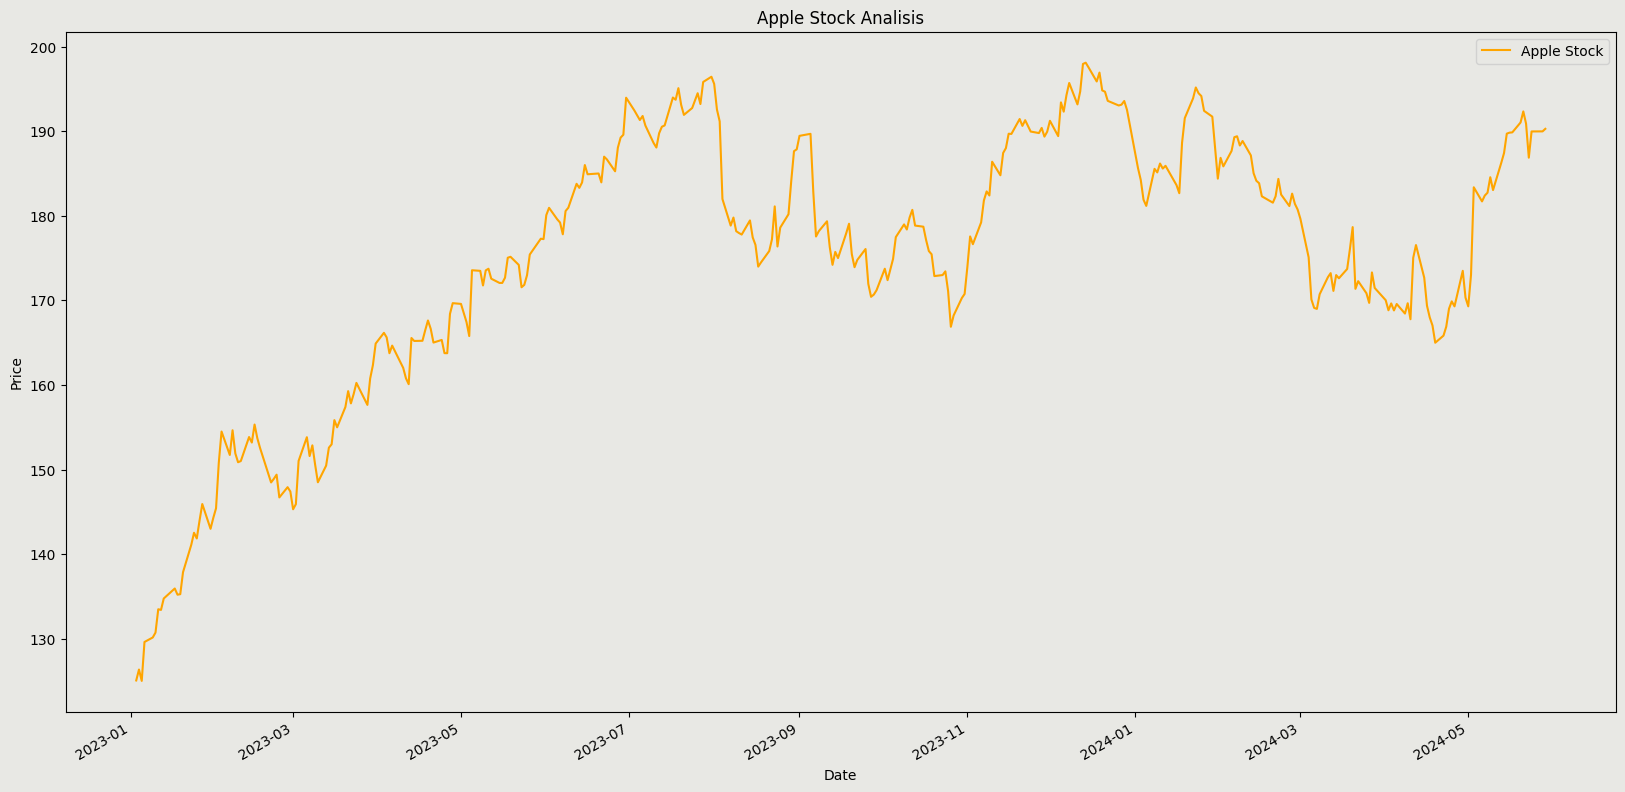

In [6]:
df["Value"].plot(figsize=(20,10),label="Apple Stock",color="orange")
plt.title("Apple Stock Analisis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().set_facecolor("#E8E8E4")
plt.gcf().set_facecolor("#E8E8E4")
plt.legend(facecolor="#E8E8E4")
plt.show()

In [7]:
timef= TransformLag()
data= timef.lag_transform(df,10)

In [8]:
df

,Value,Value (t-1),Value (t-2),Value (t-3),Value (t-4),Value (t-5),Value (t-6),Value (t-7),Value (t-8),Value (t-9),Value (t-10)
Date,,,,,,,,,,,
2023-01-18,135.21,135.94,134.76,133.41,133.49,130.73,130.15,129.62,125.02,126.36,125.07
2023-01-19,135.27,135.21,135.94,134.76,133.41,133.49,130.73,130.15,129.62,125.02,126.36
2023-01-20,137.87,135.27,135.21,135.94,134.76,133.41,133.49,130.73,130.15,129.62,125.02
2023-01-23,141.11,137.87,135.27,135.21,135.94,134.76,133.41,133.49,130.73,130.15,129.62
2023-01-24,142.53,141.11,137.87,135.27,135.21,135.94,134.76,133.41,133.49,130.73,130.15
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,190.90,192.35,191.04,189.87,189.84,189.72,187.43,186.28,183.05,184.57,182.74
2024-05-23,186.88,190.90,192.35,191.04,189.87,189.84,189.72,187.43,186.28,183.05,184.57
2024-05-24,189.98,186.88,190.90,192.35,191.04,189.87,189.84,189.72,187.43,186.28,183.05


In [9]:
data= data.to_numpy()

In [10]:
data

array([[135.21, 135.94, 134.76, ..., 125.02, 126.36, 125.07],
       [135.27, 135.21, 135.94, ..., 129.62, 125.02, 126.36],
       [137.87, 135.27, 135.21, ..., 130.15, 129.62, 125.02],
       ...,
       [189.98, 186.88, 190.9 , ..., 187.43, 186.28, 183.05],
       [189.99, 189.98, 186.88, ..., 189.72, 187.43, 186.28],
       [190.29, 189.99, 189.98, ..., 189.84, 189.72, 187.43]])

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [11]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)
transformed

array([[-1.        , -0.97678855, -1.        , ..., -1.        ,
        -0.96333288, -0.99863182],
       [-0.99809221, -1.        , -0.96274665, ..., -0.87412779,
        -1.        , -0.96333288],
       [-0.9154213 , -0.99809221, -0.98579321, ..., -0.85962512,
        -0.87412779, -1.        ],
       ...,
       [ 0.74149444,  0.64292528,  0.77237569, ...,  0.70775756,
         0.67628951,  0.58790532],
       [ 0.7418124 ,  0.74149444,  0.64546172, ...,  0.77042003,
         0.70775756,  0.67628951],
       [ 0.75135135,  0.7418124 ,  0.7433307 , ...,  0.77370365,
         0.77042003,  0.70775756]])

- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [12]:
X= transformed[:,1:]
y= transformed[:,0]

In [13]:
X

array([[-0.97678855, -1.        , -1.        , ..., -1.        ,
        -0.96333288, -0.99863182],
       [-1.        , -0.96274665, -0.95826893, ..., -0.87412779,
        -1.        , -0.96333288],
       [-0.99809221, -0.98579321, -0.92179289, ..., -0.85962512,
        -0.87412779, -1.        ],
       ...,
       [ 0.64292528,  0.77237569,  0.82194745, ...,  0.70775756,
         0.67628951,  0.58790532],
       [ 0.74149444,  0.64546172,  0.77712519, ...,  0.77042003,
         0.70775756,  0.67628951],
       [ 0.7418124 ,  0.7433307 ,  0.65285935, ...,  0.77370365,
         0.77042003,  0.70775756]])

In [14]:
X= transformed[:,1:]
y= transformed[:,0]
X= dc(np.flip(X,axis=1))
split_index= int(len(X) * 0.90)
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]
X_train= X_train.reshape((-1,10,1))
X_test= X_test.reshape((-1,10,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [15]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
seed=42
set_seed(seed)
batch_size =16
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [16]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)

torch.Size([16, 10, 1]) torch.Size([16, 1])


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss
    #     if batch_index % 100 == 99:  # print every 100 batches
    #         avg_loss_across_batches = running_loss / 100
    #         print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
    #                                                 avg_loss_across_batches))
    #         running_loss = 0.0
    # print()
    
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    return avg_loss_across_batches

    # print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    # print('***************************************************')
    # print()

Epoch 1/50, Train Loss: 0.2878341515149389, Validation Loss: 0.2811750862747431
Epoch 2/50, Train Loss: 0.2516557329467365, Validation Loss: 0.23182565486058593
Epoch 3/50, Train Loss: 0.2175987809896469, Validation Loss: 0.18208642583340406
Epoch 4/50, Train Loss: 0.18209468200802803, Validation Loss: 0.1297237309627235
Epoch 5/50, Train Loss: 0.1452863421291113, Validation Loss: 0.08107972051948309
Epoch 6/50, Train Loss: 0.11673799423234803, Validation Loss: 0.0484920097514987
Epoch 7/50, Train Loss: 0.09828512018014278, Validation Loss: 0.03435806557536125
Epoch 8/50, Train Loss: 0.08334026818296739, Validation Loss: 0.026055389549583197
Epoch 9/50, Train Loss: 0.06938105409166642, Validation Loss: 0.01978068659082055
Epoch 10/50, Train Loss: 0.05774531260664974, Validation Loss: 0.017318286874797195
Epoch 11/50, Train Loss: 0.048921930071498664, Validation Loss: 0.016641312089632265
Epoch 12/50, Train Loss: 0.042702807379620414, Validation Loss: 0.01718853171155388
Epoch 13/50, Tr

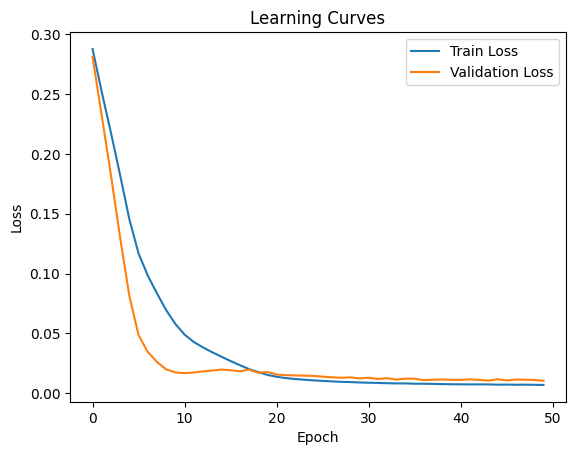

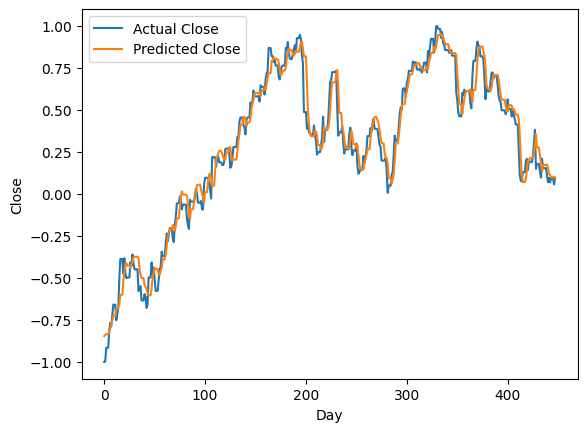

In [20]:


train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    val_loss= validate_one_epoch()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

# Plotting the learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [21]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 10+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([140.04280006, 140.2761348 , 140.42042577, 140.42042577,
       140.42042577, 140.7786741 , 141.51701881, 142.39680891,
       142.98495776, 143.80786415, 143.80786415, 143.80786415,
       144.92343155, 145.09008047, 145.41721475, 145.92191542,
       147.7746728 , 147.7746728 , 147.7746728 , 150.56005867,
       151.68646761, 153.53210633, 153.69663699, 153.24050351,
       153.24050351, 153.24050351, 152.85029196, 153.51411611,
       153.75400059, 154.76678459, 154.8984363 , 154.8984363 ,
       154.8984363 , 154.8984363 , 154.50962693, 152.6810402 ,
       151.54324139, 150.91798269, 150.91798269, 150.91798269,
       149.689737  , 149.2408984 , 148.87191256, 148.05931066,
       147.68726366, 147.68726366, 147.68726366, 148.97219247,
       151.04593307, 151.82322377, 152.81720119, 152.61801917,
       152.61801917, 152.61801917, 151.61404094, 151.50882342,
       152.16389616, 152.80388146, 154.41097601, 154.41097601,
       154.41097601, 155.29307182, 156.88797045, 158.76

In [22]:
dummies = np.zeros((X_train.shape[0], 10+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([135.21      , 135.26999924, 137.86999989, 137.86999989,
       137.86999989, 141.1099999 , 142.53000058, 141.86000067,
       143.96000019, 145.93000042, 145.93000042, 145.93000042,
       142.99999928, 144.29000067, 145.42999929, 150.81999912,
       154.50000009, 154.50000009, 154.50000009, 151.72999972,
       154.65000006, 151.92000012, 150.86999942, 151.01000045,
       151.01000045, 151.01000045, 153.84999993, 153.19999976,
       155.32999984, 153.70999983, 152.5499996 , 152.5499996 ,
       152.5499996 , 152.5499996 , 148.48000078, 148.90999999,
       149.40000032, 146.70999987, 146.70999987, 146.70999987,
       147.92000041, 147.41000034, 145.31000082, 145.91000068,
       151.0300002 , 151.0300002 , 151.0300002 , 153.83000018,
       151.60000044, 152.87000021, 150.58999924, 148.50000053,
       148.50000053, 148.50000053, 150.47000076, 152.59000003,
       152.98999962, 155.84999978, 155.00000029, 155.00000029,
       155.00000029, 157.39999974, 159.28000019, 157.82

In [23]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 10+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([169.9921818 , 169.35120673, 172.58964054, 172.58964054,
       172.58964054, 175.54346179, 175.21186324, 172.88781043,
       170.50013344, 168.59704314, 168.59704314, 168.59704314,
       166.63019264, 166.08187878, 166.58239191, 168.17621993,
       169.76934885, 169.76934885, 169.76934885, 170.41530229,
       172.75529876, 172.50721306, 171.51501695, 172.66389866,
       172.66389866, 172.66389866, 178.57191327, 181.48313314,
       183.14458542, 183.90186138, 184.87633393, 184.87633393,
       184.87633393, 184.48523572, 185.64484792, 186.87368784,
       188.58252166, 189.56572594, 189.56572594, 189.56572594,
       190.02089495, 190.67986867, 191.57103176, 191.38014094,
       189.27666598, 189.27666598, 189.27666598, 189.27666598,
       189.39822596, 189.61963471])

In [24]:
dummies = np.zeros((X_test.shape[0], 10+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([167.78000004, 175.04000021, 176.54999974, 176.54999974,
       176.54999974, 172.69000012, 169.38000007, 168.00000005,
       167.04      , 165.00000004, 165.00000004, 165.00000004,
       165.84000001, 166.90000001, 169.01999996, 169.8899999 ,
       169.29999991, 169.29999991, 169.29999991, 173.50000012,
       170.32999993, 169.29999991, 173.03000001, 183.38000093,
       183.38000093, 183.38000093, 181.70999969, 182.40000028,
       182.7399997 , 184.56999984, 183.05000044, 183.05000044,
       183.05000044, 186.27999964, 187.42999907, 189.72000085,
       189.83999933, 189.86999988, 189.86999988, 189.86999988,
       191.04000093, 192.35000019, 190.90000084, 186.8799995 ,
       189.97999942, 189.97999942, 189.97999942, 189.97999942,
       189.99000023, 190.29000016])

- El modelo puede claramente tener una idea de los patrones de los datos pero no de la escala
- El modelo se ha entrenado con datos muy antiguos que no tienen similitud con los datos actuales, habria que repetir el proceso de transformaciones y re-entrenar el modelo con datos mas recientes

In [25]:
print(test_predictions)

[169.9921818  169.35120673 172.58964054 172.58964054 172.58964054
 175.54346179 175.21186324 172.88781043 170.50013344 168.59704314
 168.59704314 168.59704314 166.63019264 166.08187878 166.58239191
 168.17621993 169.76934885 169.76934885 169.76934885 170.41530229
 172.75529876 172.50721306 171.51501695 172.66389866 172.66389866
 172.66389866 178.57191327 181.48313314 183.14458542 183.90186138
 184.87633393 184.87633393 184.87633393 184.48523572 185.64484792
 186.87368784 188.58252166 189.56572594 189.56572594 189.56572594
 190.02089495 190.67986867 191.57103176 191.38014094 189.27666598
 189.27666598 189.27666598 189.27666598 189.39822596 189.61963471]


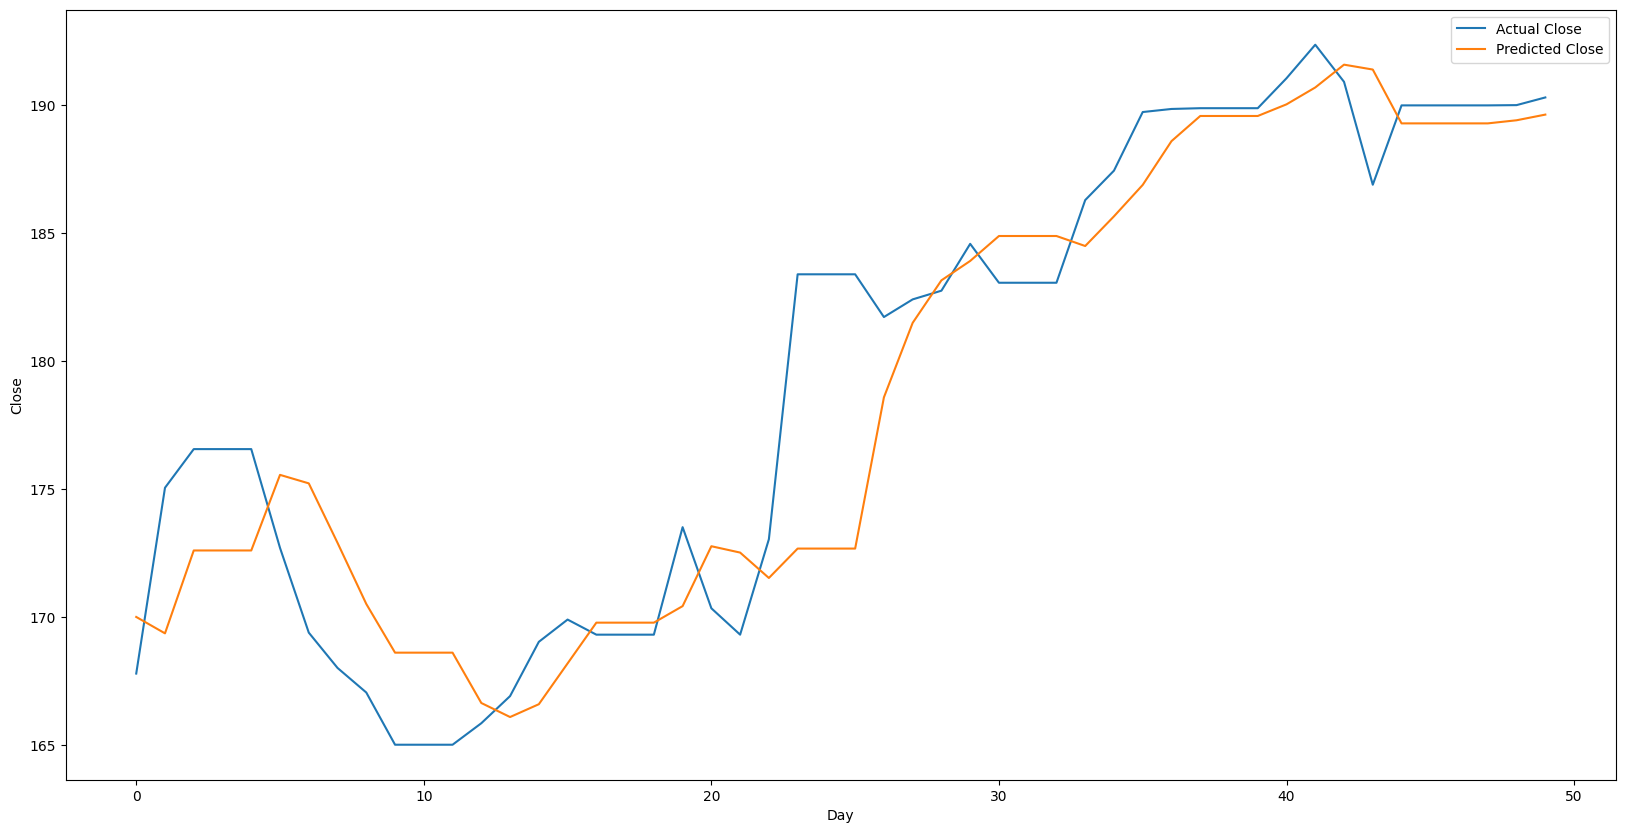

In [26]:
plt.figure(figsize=(20,10))
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()